# Previsão de renda

### 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

## Etapa 1 CRISP - DM: Entendimento do negócio

Um banco deseja prever a renda de seus clientes, esta informação pode ser útil por exemplo para ofertar diferentes classes de cartões para o cliente. Com uma base de dados contendo informações bancárias é possível analisar a relação da renda com outra informações e gerar previsões sobre novos clientes.

O seguinte projeto realiza uma análise e modelagem estatística de um modelo para a previsão de renda. As visualizações centrais e mais informativas estão apresentadas com a biblioteca Streamlit.


## Etapa 2 Crisp-DM: Entendimento dos dados

* Fonte:

Os dados utilizados foram fornecidos pelo curso Cientista de Dados da EBAC e utilizado em projetos anteriores.


### Dicionário de dados



| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data da aplicação                                       | object|
| id_cliente              |  Identificador unico do cliente                                      | int64|
| sexo                    | Sexo do cliente                                      | object|
| posse_de_veiculo        |  Indicação de posse de veículo                                      | bool|
| posse_de_imovel         | Indicação de posse de imóvel                                     | bool|
| qtd_filhos              | Quantidade de filhos do cliente                                      | int64|
| tipo_renda              |  Fonte da renda do cliente                                      | object|
| educacao                |  Nível de educação formal do cliente                                    | object|
| estado_civil            |  Estado civil do cliente                                      | object|
| tipo_residencia         |  Tipo de residência do cliente                                     | object|
| idade                   |  Idade do cliente                                      | int64|
| tempo_emprego           | Tempo (em anos) em que o cliente esta empregado                                      | float64|
| qt_pessoas_residencia   |  Quantidade de pessoas na residência do cliente                                      | int64|
| renda                   |  Renda do cliente                                      | float64|





#### Carregando os pacotes

* Bibliotecas:

In [76]:
import pandas as pd
import patsy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

In [32]:
# Problema na biblioteca:

# import ydata_profiling

#### Carregando os dados


In [33]:
renda = pd.read_csv('./input/previsao_de_renda.csv')

In [34]:
# Amostra dos dados

renda.sample(n=3)

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
9625,9625,2015-10-01,15642,M,True,True,0,Empresário,Secundário,União,Casa,29,2.712329,2.0,2393.59
4409,4409,2015-05-01,362,F,False,False,0,Empresário,Superior completo,Casado,Casa,27,1.857534,2.0,4142.70
5998,5998,2015-06-01,13084,F,False,False,0,Pensionista,Secundário,Casado,Casa,62,NaN,2.0,1755.27


#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis. 

In [35]:
#prof = ProfileReport(renda, explorative=True, minimal=True)
#prof


In [36]:
#prof.to_file('./output/renda_analisys.html')

### Entendimento dos dados - Bivariadas




* Verificando as correlações nas variáveis numéricas:

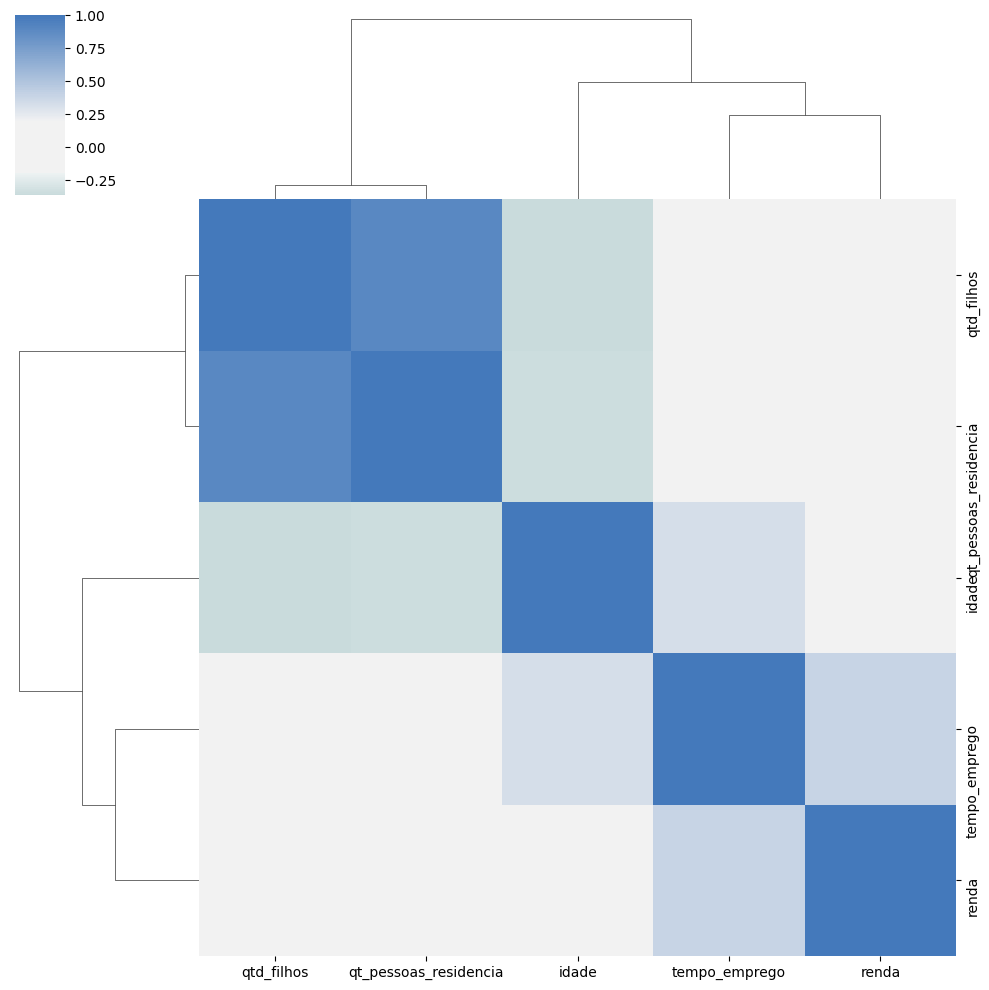

In [37]:
renda_num = renda.select_dtypes(exclude=['object', 'bool'])
cm =sns.diverging_palette(h_neg=200, h_pos=250, as_cmap=True, sep=50, center='light')
sns.clustermap(renda_num.drop(['id_cliente', 'Unnamed: 0'], axis=1).corr(), center=0, cmap=cm)

Das variáveis numéricas, a renda tem uma correlação relevante apenas com a variável 'tempo_emprego'

<Axes: title={'center': 'Renda em função do tempo empregado'}, xlabel='tempo_emprego', ylabel='renda'>

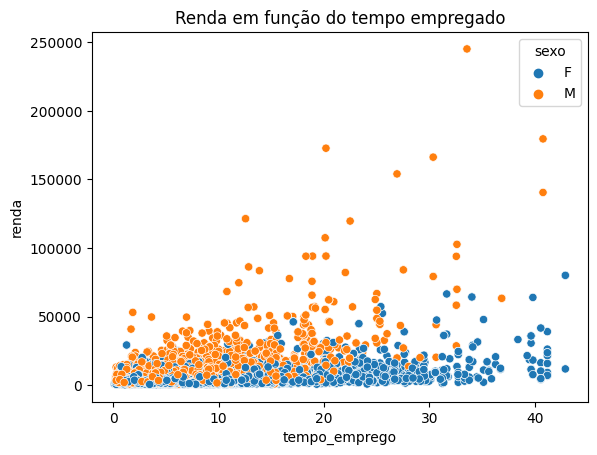

In [38]:
plt.title('Renda em função do tempo empregado')
sns.scatterplot(data=renda.dropna(), x='tempo_emprego', y='renda', hue='sexo')

Podemos notar a pequena correlação entre renda e tempo empregado como esperado. Esta correlação apresenta diferentes valores para clientes de sexo masculino e feminino. Espera-se que a renda média por sexo seja diferente e que estas duas variáveis tenham um potencial preditivo sobre a renda.

In [39]:
# Função para pointplot:

def graf_point(var: str):
    """ Recebe a string de uma variável categórica e retorna
    um pointplot da renda média em função da variável
    """
    plt.figure(figsize=(10,6))
    sns.pointplot(data=renda, x=var, y='renda')
    plt.title(f'Renda média em função de {var}')
    plt.ylabel('Renda média')

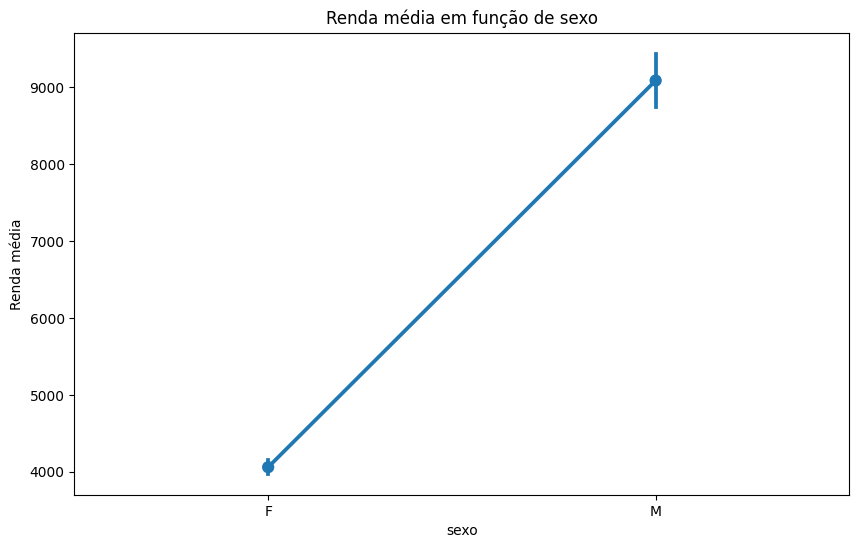

In [40]:
# Relação da renda média em função do sexo:
graf_point('sexo')

Confirmando a hipótese anterior, a renda média é estatisticamente diferente para cada sexo.

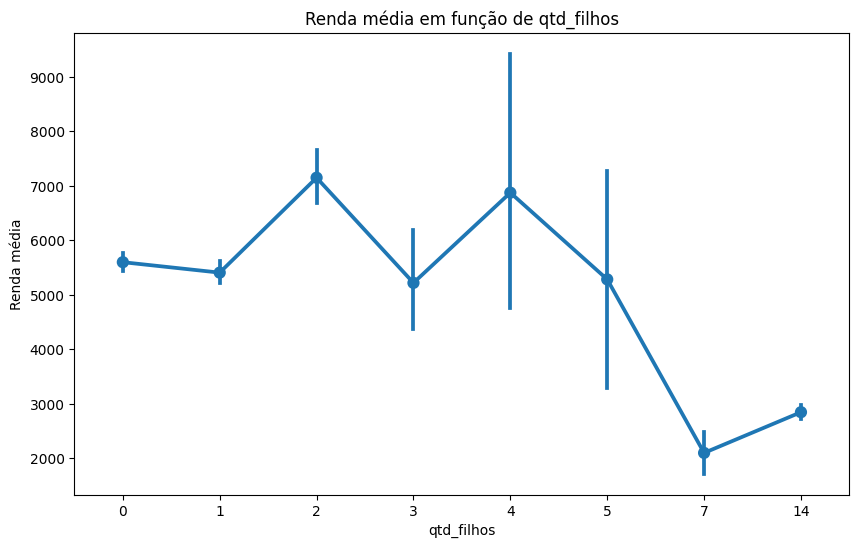

In [41]:
# Outra variável interessante é quantidade de filhos do cliente, vamos analisar com o pointplot
# se diverentes valores apontam para rendas médias estatisticamente diferentes:

graf_point('qtd_filhos')

Podemos notar pelos intervalos de confiança a interceção de varios valores, explicando o motivo desta variável tem uma baixa correlação com a renda.

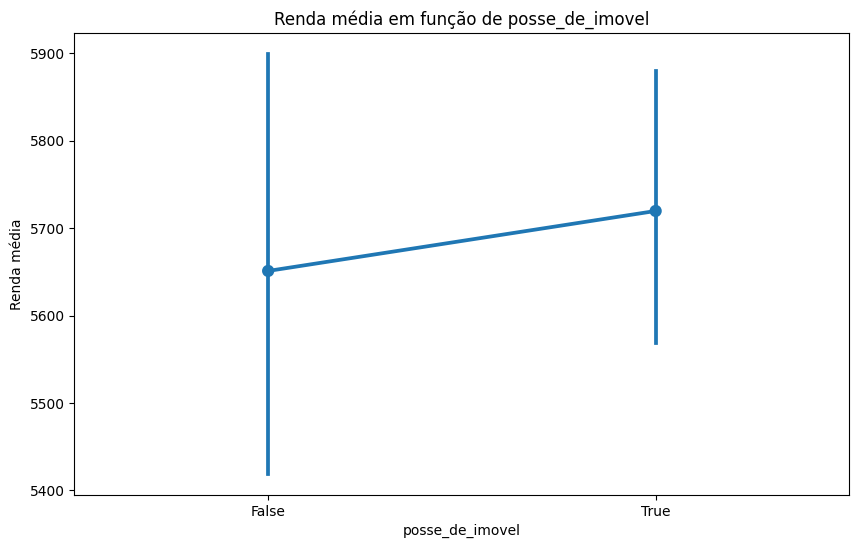

In [42]:
# Relação da renda média em função daposse de imóvel:
graf_point('posse_de_imovel')

Não podemos afirmar que é possivel diferenciar a renda média com base na posse de imóvel.

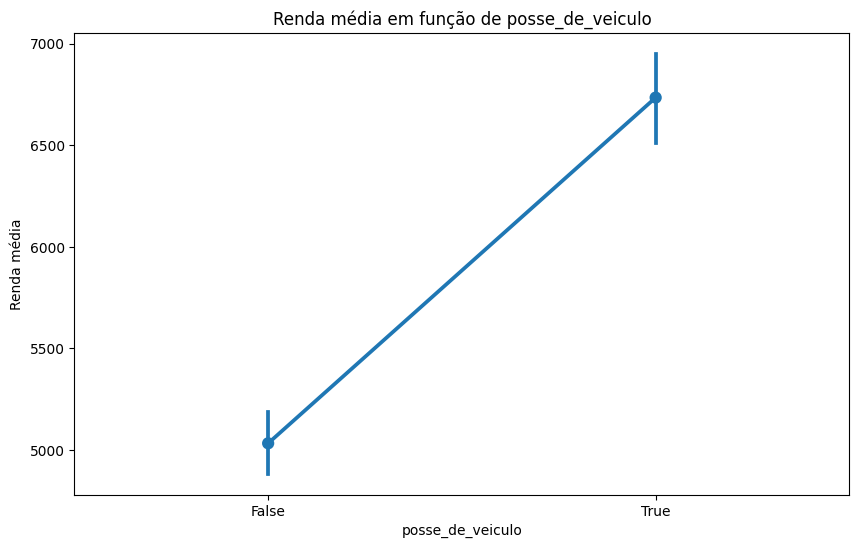

In [43]:
# Relação da renda média em função daposse de veículo:
graf_point('posse_de_veiculo')

Posse de veículo é estatisticamente relevante para diferenciar a renda média do cliente.

* Analisando a relação da renda com outras variáveis categóricas:

In [44]:
# Função para gráficos de barras:

def graf_bar(var: str):
    """ Recebe a string de uma variável categórica e retorna
    um barplot da renda média em função da variável
    """
    gi = renda.groupby(var)['renda'].mean().sort_values()
    plt.figure(figsize=(15,8))
    sns.barplot(x=gi.index, y=gi, palette='viridis', errorbar=('ci', 90))
    plt.title(f'Renda média em função de {var}')
    plt.ylabel('Renda média')

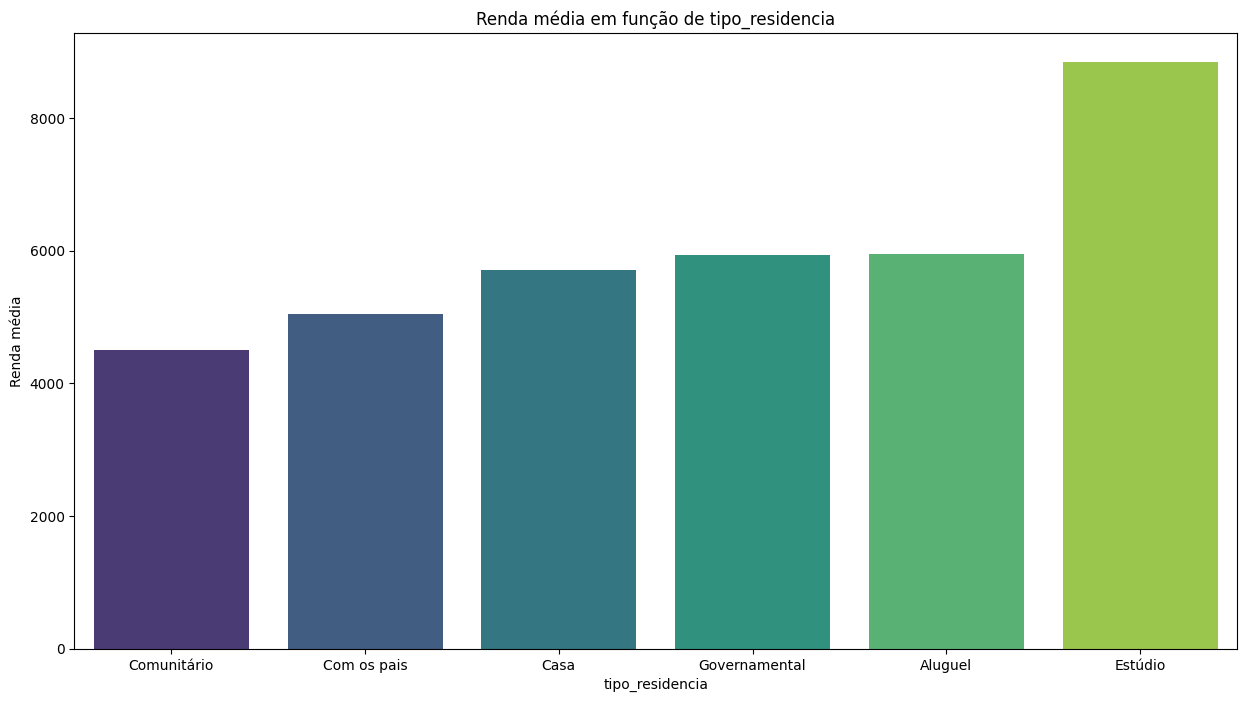

In [45]:
# Em função da residência:

graf_bar('tipo_residencia')

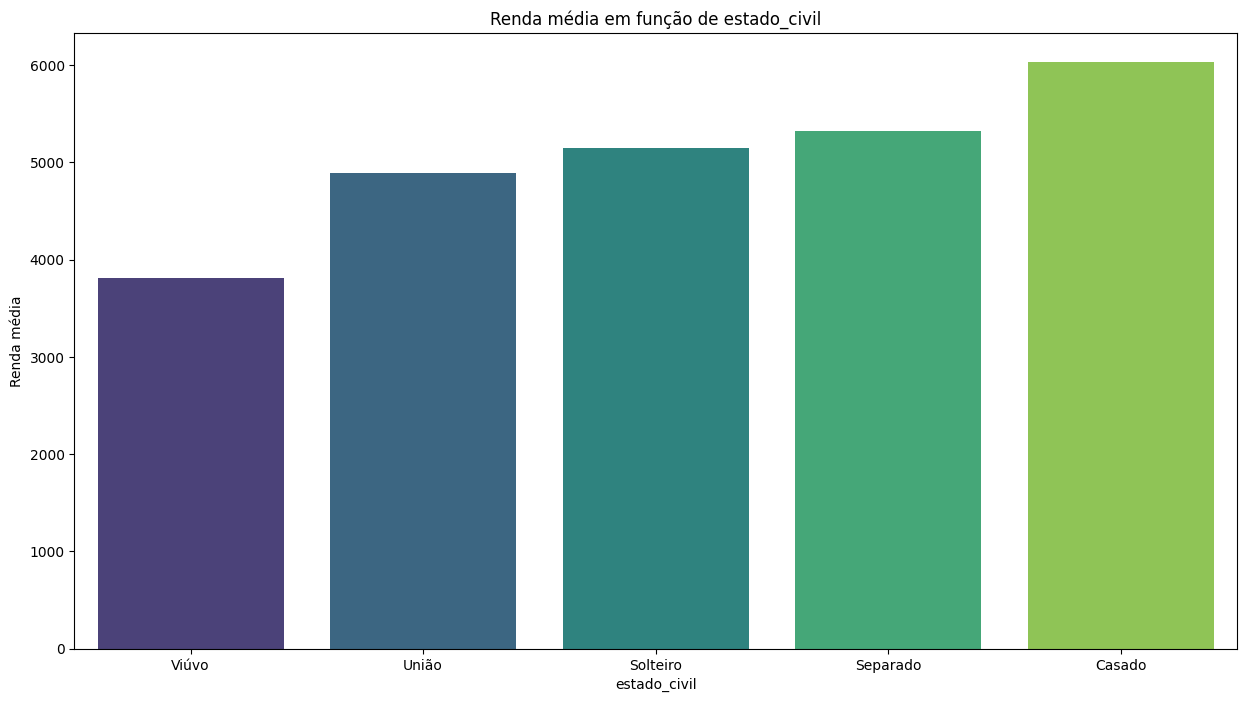

In [46]:
# Em função do estado civíl:

graf_bar('estado_civil')

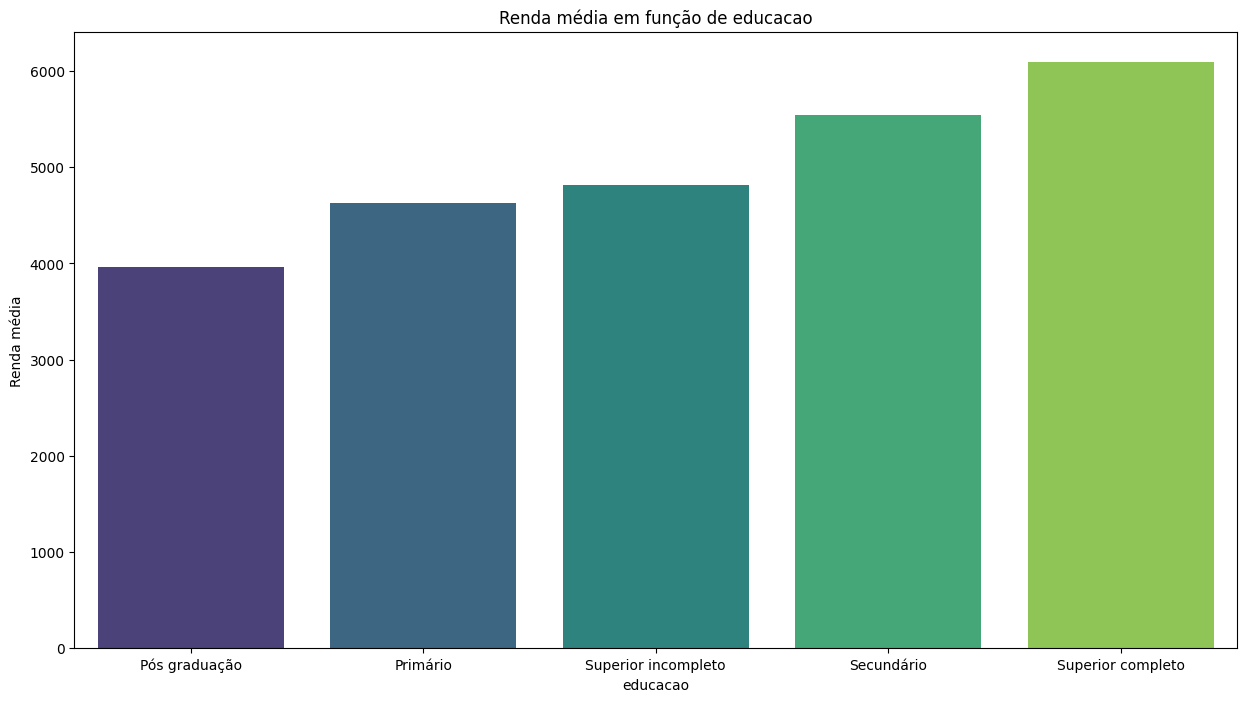

In [47]:
# Em função da escolaridade:

graf_bar('educacao')

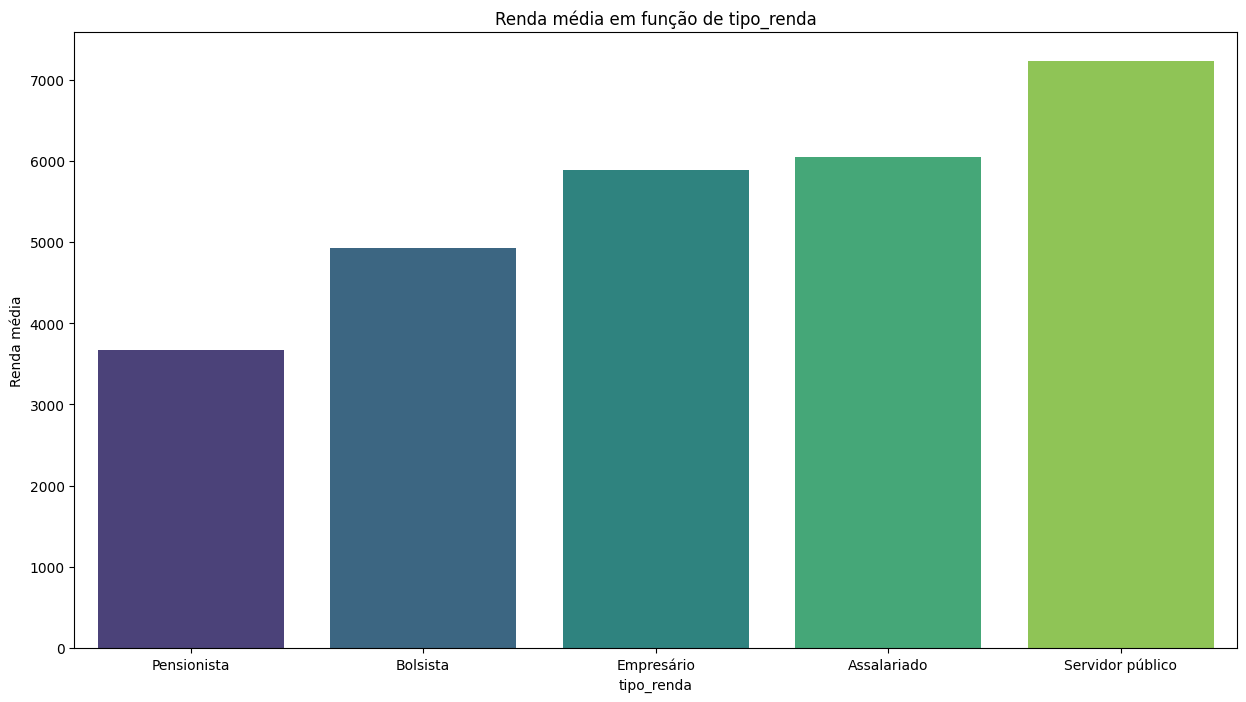

In [48]:
# Em função do tipo da renda:

graf_bar('tipo_renda')

Podemos notar pelos gráficos de barras diferentes valores médios de renda para diferentes classes das variáveis aboradadas, mostrando que os dados categóricos contém informações relevantes para a determinação da renda.

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



* Seleção:

Excluíndo variáveis que não serão importantes:


In [49]:
renda = renda.drop(['id_cliente', 'Unnamed: 0', 'data_ref'], axis=1)

* Limpeza:

Verificando a existência e proporção de dados faltantes:

In [50]:
# Utilizando uma função para conferir a presença de dados faltantes:

def stat_dados_faltantes(df: pd.DataFrame) ->  None:

    """Recebe um dataframe e retorna um dicionário com o nome da variável e a 
    porcentagem de dados faltantes variável. Caso não existam dados faltantes em nenhuma
    variável, retorna uma mensagem."""
    
    stat_dados_faltantes = []

    if df.isnull().any().sum()>0:
        for col in df.columns:
            if df[col].isnull().any():
                qnt = df[df[col].isna()].shape[0]
                total = df.shape[0]
                dic = {col: {'quantidade': qnt, 'porcentagem': round(qnt/total*100, 2)}}
                stat_dados_faltantes.append(dic)
    else:
        print('Dataframe não contém dados faltantes.')
    for stat in stat_dados_faltantes:
        print(stat)

In [51]:
# Verificando dados faltantes:

stat_dados_faltantes(renda)

{'tempo_emprego': {'quantidade': 2573, 'porcentagem': 17.15}}


In [52]:
# Removendo dados faltantes:

renda.dropna(subset='tempo_emprego', inplace=True)

* Formatação:

Com o dataset limpo, realizaremos algumas transformações para formatar os dados para a construção do modelo.

Antes da fromatação, realizaremos uma ultima análise e seleção de variáveis estatísticamente relevantes utilizando a biblioteca statsmodels:

In [53]:
# Como visto anteriormente, a posse de imóvel não tem uma relação relevante com a renda

renda.drop(['posse_de_imovel'], axis=1, inplace=True)

In [56]:
# Criando matrizes para explicar a variável renda em função das demais variáveis:

y, X = patsy.dmatrices("""renda ~ sexo + posse_de_veiculo
                         + qtd_filhos + C(tipo_renda)
                         + C(educacao) + C(estado_civil) + C(tipo_residencia)
                         + idade + tempo_emprego + qt_pessoas_residencia"""
                         , data=renda)

# Criando um modelo de regressão para previsão da renda:

reg = sm.OLS(y,X).fit()

# Visualizando o resumo de métricas associadas com a regressão:

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     185.4
Date:                Wed, 27 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:41:31   Log-Likelihood:            -1.2879e+05
No. Observations:               12427   AIC:                         2.576e+05
Df Residuals:                   12403   BIC:                         2.578e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                           -5517.7057   2500.356     -2.207      0.027   -1.04e+04    -616.621
sexo[T.M]                            6039.7454    155.800     38.766      0.000    5734.353    6345.137
posse_de_veiculo[T.True]               58.6610    150.352      0.390      0.696    -236.053     353.375
C(tipo_renda)[T.Bolsista]           -1257.9957   2565.038     -0.490      0.624   -6285.869    3769.877
C(tipo_renda)[T.Empresário]           824.8771    158.857      5.193      0.000     513.493    1136.261
C(tipo_renda)[T.Pensionista]        -2776.3421   2565.733     -1.082      0.279   -7805.576    2252.892
C(tipo_renda)[T.Servidor público]     129.9580    236.357      0.550      0.582    -333.339     593.255
C(educacao)[T.Pós graduação]         1171.8906   1690.419      0.693      0.488   -2141.594    4485.375
C(educacao)[T.Secundário]             584.3539    765.786      0.763      0.445    -916.706    2085.414
C(educacao)[T.Superior completo]     1208.3534    768.690      1.572      0.116    -298.398    2715.105
C(educacao)[T.Superior incompleto]    178.9853    827.095      0.216      0.829   -1442.250    1800.221
C(estado_civil)[T.Separado]          1161.8612   1183.211      0.982      0.326   -1157.415    3481.138
C(estado_civil)[T.Solteiro]           862.4209   1158.314      0.745      0.457   -1408.055    3132.897
C(estado_civil)[T.União]             -487.5207    267.726     -1.821      0.069   -1012.306      37.264
C(estado_civil)[T.Viúvo]             1094.1545   1229.537      0.890      0.374   -1315.930    3504.239
C(tipo_residencia)[T.Casa]           -255.1816    575.673     -0.443      0.658   -1383.590     873.227
C(tipo_residencia)[T.Com os pais]    -457.4229    641.371     -0.713      0.476   -1714.610     799.765
C(tipo_residencia)[T.Comunitário]    -470.3028   1120.742     -0.420      0.675   -2667.132    1726.526
C(tipo_residencia)[T.Estúdio]          70.0952   1056.398      0.066      0.947   -2000.610    2140.800
C(tipo_residencia)[T.Governamental]   -15.8382    700.902     -0.023      0.982   -1389.715    1358.039
qtd_filhos                          -1145.4212   1148.125     -0.998      0.318   -3395.924    1105.082
idade                                  43.6968      8.491      5.146      0.000      27.052      60.341
tempo_emprego                         554.0322     11.043     50.172      0.000     532.387     575.677
qt_pessoas_residencia                1296.5183   1146.051      1.131      0.258    -949.920    3542.956
==============================================================================
Omnibus:                    17559.939   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9849327.321
Skew:                           8.118 

Podemos notar a métrica 'P value' relacionada a cada variável e suas classes, algumas delas apresentam um valor alto (maior que 0.5) indicando que esta classe não tem uma capacidade preditiva alta em relação a renda. Entre estas a variável 'tipo_residencia' e suas classes apresentam as piores métricas.

Treinaremos novamente a regressão, removendo variáveis pouco preditivas a fim de simplificar o modelo:

In [66]:
y, X = patsy.dmatrices("""renda ~ sexo
                         + qtd_filhos + C(tipo_renda)
                         + C(educacao) + C(estado_civil)
                         + idade + tempo_emprego"""
                         , data=renda)

# Criando um modelo de regressão para previsão da renda:

reg = sm.OLS(y,X).fit()

# Visualizando o resumo de métricas associadas com a regressão:

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     266.5
Date:                Wed, 27 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:53:23   Log-Likelihood:            -1.2879e+05
No. Observations:               12427   AIC:                         2.576e+05
Df Residuals:                   12410   BIC:                         2.577e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                          -3200.6858    831.024     -3.851      0.000   -4829.622   -1571.750
sexo[T.M]                           6059.7645    147.511     41.080      0.000    5770.619    6348.910
C(tipo_renda)[T.Bolsista]          -1282.5270   2563.972     -0.500      0.617   -6308.310    3743.256
C(tipo_renda)[T.Empresário]          830.8059    158.539      5.240      0.000     520.045    1141.567
C(tipo_renda)[T.Pensionista]       -2774.1946   2565.004     -1.082      0.279   -7802.000    2253.611
C(tipo_renda)[T.Servidor público]    132.5646    236.092      0.561      0.574    -330.211     595.341
C(educacao)[T.Pós graduação]        1193.5643   1688.093      0.707      0.480   -2115.361    4502.489
C(educacao)[T.Secundário]            595.7575    763.438      0.780      0.435    -900.699    2092.214
C(educacao)[T.Superior completo]    1217.3697    766.689      1.588      0.112    -285.460    2720.199
C(educacao)[T.Superior incompleto]   179.7928    825.374      0.218      0.828   -1438.069    1797.655
C(estado_civil)[T.Separado]         -151.5521    295.997     -0.512      0.609    -731.753     428.648
C(estado_civil)[T.Solteiro]         -430.6793    216.504     -1.989      0.047    -855.060      -6.298
C(estado_civil)[T.União]            -500.6437    266.830     -1.876      0.061   -1023.672      22.384
C(estado_civil)[T.Viúvo]            -208.7953    443.155     -0.471      0.638   -1077.448     659.858
qtd_filhos                           150.2809     92.640      1.622      0.105     -31.308     331.869
idade                                 44.3958      8.392      5.290      0.000      27.946      60.845
tempo_emprego                        554.0978     11.027     50.248      0.000     532.483     575.713
==============================================================================
Omnibus:                    17562.693   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9868000.360
Skew:                           8.120   Prob(JB):                         0.00
Kurtosis:                     140.092   Cond. No.                     1.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Por fim sobramos com as variáveis:
 ['sexo', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'idade', 'tempo_emprego']

In [68]:
# Criando um novo dataset com as variáveis relevantes e a variável alvo:

var_relevantes = ['sexo', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'idade', 'tempo_emprego', 'renda']
data = renda[var_relevantes]

data.sample(n=3)

,sexo,qtd_filhos,tipo_renda,educacao,estado_civil,idade,tempo_emprego,renda
10325,M,0,Assalariado,Superior incompleto,Casado,47,2.347945,2783.69
5886,F,0,Assalariado,Secundário,União,40,21.443836,5073.42
11336,M,0,Servidor público,Superior completo,Casado,33,6.336986,3203.36


In [69]:
# Realizando as ultimas transformações de tipos de dados e criação de dummies para variáveis
# categóricas:

data = pd.get_dummies(data, columns=['tipo_renda', 'educacao', 'estado_civil'], dtype=int)
data['sexo'] = data['sexo'].map({'M': 1, 'F':0})

data.sample(n=3)

,sexo,qtd_filhos,idade,tempo_emprego,renda,tipo_renda_Assalariado,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor público,educacao_Primário,educacao_Pós graduação,educacao_Secundário,educacao_Superior completo,educacao_Superior incompleto,estado_civil_Casado,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo
251,0,1,30,5.657534,3594.85,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
9131,0,1,36,12.183562,2999.59,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
11560,0,0,31,2.682192,3082.98,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [70]:
# Separação das variáveis preditivas e a variável alvo:

X = data.drop('renda', axis=1)
y = data['renda']

# Separação do conjunto de treino e teste:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


* Selecionando uma técnica:

Para o projeto, daremos continuidade no estudo e aplicação das árvores de decisão. O intúito do projeto é prever a renda, portanto utilizaremos uma árvore de regressão.


In [71]:
modelo = DecisionTreeRegressor(random_state=42)

### Rodando o modelo


In [78]:
# treinando o modelo com o conjunto de dados de treino:

modelo.fit(X_train, y_train)

# Métricas obtidas no conjunto de treino e teste:

print('Conjunto de treino:')
print(f'R^2: {r2_score(y_train, modelo.predict(X_train))}')
print(f'Erro médio absoluto: {round(mean_absolute_error(y_train, modelo.predict(X_train)),2)}')
print('\nConjunto de teste:')
print(f'R^2: {r2_score(y_test, modelo.predict(X_test))}')
print(f'Erro médio absoluto: {round(mean_absolute_error(y_test, modelo.predict(X_test)),2)}')

Conjunto de treino:
R^2: 0.8285436924538891
Erro médio absoluto: 1486.81

Conjunto de teste:
R^2: 0.20313714298560148
Erro médio absoluto: 3200.51


* Otimização e Tunning de hiperparâmetros:

In [79]:
# Utilizando o RandomizedSearchCV para encontrar os melhores hiperparâmetros:

kfold = KFold(n_splits=4, shuffle=True)

# Hiperparâmetros avaliados

parametros = {
    'criterion': ['absolute_error', 'poisson', 'squared_error', 'friedman_mse'],
    'max_depth': range(1,12),
    'min_samples_split': range(2,10,2),
    'min_samples_leaf': range(2,10,2)
}

# Otimização buscando melhoria nas métricas r^2 e MSE

search = RandomizedSearchCV(modelo, parametros, scoring=['r2', 'neg_mean_squared_error'], refit='r2', cv=kfold)
resultado = search.fit(X_train, y_train)

print("Melhores parâmetros encontrados:", resultado.best_params_)

Melhores parâmetros encontrados: {'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'squared_error'}


* Modelo final:

In [80]:
# Treinando o modelo final:

modelo_final = DecisionTreeRegressor(random_state=42,
                            min_samples_leaf=2,
                            min_samples_split=6,
                            max_depth=5,
                            criterion='squared_error'
)

modelo_final.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=6,
                      random_state=42)

## Etapa 5 Crisp-DM: Avaliação dos resultados


* Avaliação das novas métricas do modelo final:

In [82]:
# Métricas obtidas no conjunto de treino e teste:

print('Conjunto de treino:')
print(f'R^2: {r2_score(y_train, modelo_final.predict(X_train))}')
print(f'Erro médio absoluto: {round(mean_absolute_error(y_train, modelo_final.predict(X_train)),2)}')
print('\nConjunto de teste:')
print(f'R^2: {r2_score(y_test, modelo_final.predict(X_test))}')
print(f'Erro médio absoluto: {round(mean_absolute_error(y_test, modelo_final.predict(X_test)),2)}')

Conjunto de treino:
R^2: 0.5507496743439037
Erro médio absoluto: 3345.63

Conjunto de teste:
R^2: 0.3348592424379365
Erro médio absoluto: 3414.4


In [84]:
# Comparação da renda média com o erro médio absoluto:

print('Razão da renda média com o erro médio no conjunto de treino:')
print(renda['renda'].mean()/mean_absolute_error(y_train, modelo_final.predict(X_train)))
print('\nRazão da renda média com o erro médio no conjunto de treino:')
print(renda['renda'].mean()/mean_absolute_error(y_test, modelo_final.predict(X_test)))

Razão da renda média com o erro médio no conjunto de treino:
1.8282174635482618

Razão da renda média com o erro médio no conjunto de treino:
1.7913946027308558


Podemos notar que o modelo final apresenta um aumento na capacidade de explicar a variável renda, indicado pela métrica 'r^2' e que a média dos valores de renda é maior que os erros médios da previsão, demonstrando a eficiência das previsões em um intervalo razoavel.

## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.

* Como citado anteriormente, pode ser do interesse do banco determinar a renda do cliente para ofertar diferentes produtos. Por exemplo, suponha que o banco tem 4 classes de cartões de créditos e irá oferecer estes cartões a diferentes tipos de clientes se baseando na renda:

In [89]:
# Determinando os quartis das rendas:

q1, q2, q3 = y.quantile([0.25, 0.5, 0.75])

print('Quartis da renda que serão utilizados na classificação:')
print(round(q1,2), q2, q3)

2117.23 3681.05 6846.65


In [95]:
def oferta_cartao(x: pd.DataFrame):
    """
    A função recebe um dataframe contendo as informações bancárias de um cliente
    e retorna o tipo de cartão que será ofertado a ele
    """
    renda_cliente = modelo_final.predict(x)

    if renda_cliente < q1:
        print(f'Renda prevista: {renda_cliente}')
        print('Cartão Bronze')
    elif renda_cliente < q2:
        print(f'Renda prevista: {renda_cliente}')
        print('Cartão Prata')
    else:
        print(f'Renda prevista: {renda_cliente}')
        print('Cartão Ouro')

In [102]:
# Exemplo:

# Pegando uma amostra dos dados:

x_teste = X.sample(n=1)
x_teste


,sexo,qtd_filhos,idade,tempo_emprego,tipo_renda_Assalariado,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor público,educacao_Primário,educacao_Pós graduação,educacao_Secundário,educacao_Superior completo,educacao_Superior incompleto,estado_civil_Casado,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo
8014,1,1,41,5.923288,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0


In [103]:
# Utilizando a função:

oferta_cartao(x_teste)

Renda prevista: [6920.06004478]
Cartão Ouro
